In [680]:
import pandas as pd
import numpy as np
import scipy as sc
import re

from sklearn import ensemble
from sklearn.svm import SVC as SVM
from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectFdr

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import Levenshtein
import itertools

In [453]:
DS_lambada = pd.read_csv('Prep_Lambada.csv', sep=";")
DS_tacmono = pd.read_csv('Prep_TACmono.csv', sep=";")
try:
    DS_lambada.drop('Unnamed: 0', axis=1, inplace=True)
except:
    print('--continuing')
try:
    DS_tacmono.drop('Unnamed: 0', axis=1, inplace=True)
except:
    print('--continuing')


--continuing


In [454]:
# create all possible word pairs
columns_lamba = DS_lambada.columns.str.lower().values
DS_lambada.columns = columns_lamba
columns_tacmono = DS_tacmono.columns.str.lower().values
DS_tacmono.columns = columns_tacmono

In [455]:
col_combos = [(x,y) for x in columns_lamba 
                    for y in columns_tacmono]

In [456]:
combo_list = []
for combo in col_combos:
    _jw = Levenshtein.jaro_winkler(combo[0], combo[1])
    _lev = Levenshtein.distance(combo[0], combo[1])
    
    combo_list.append({'col_lam': combo[0], 
                       'col_tac': combo[1], 
                       'dist_jw': (1-_jw), 
                       'dist_lev': _lev,
                       'wl_lam': len(combo[0]),
                       'wl_tac': len(combo[1])})
combo_df = pd.DataFrame(combo_list)

In [457]:
combo_df.dist_lev = combo_df[['dist_lev', 'wl_lam', 'wl_tac']].apply(lambda x: x[0]/np.max([x[1], x[2]]), axis=1)

In [458]:
best_combos_jw = combo_df.loc[combo_df.groupby(by='col_lam')['dist_jw'].idxmin()]
best_combos_lev = combo_df.loc[combo_df.groupby(by='col_lam')['dist_lev'].idxmin()]

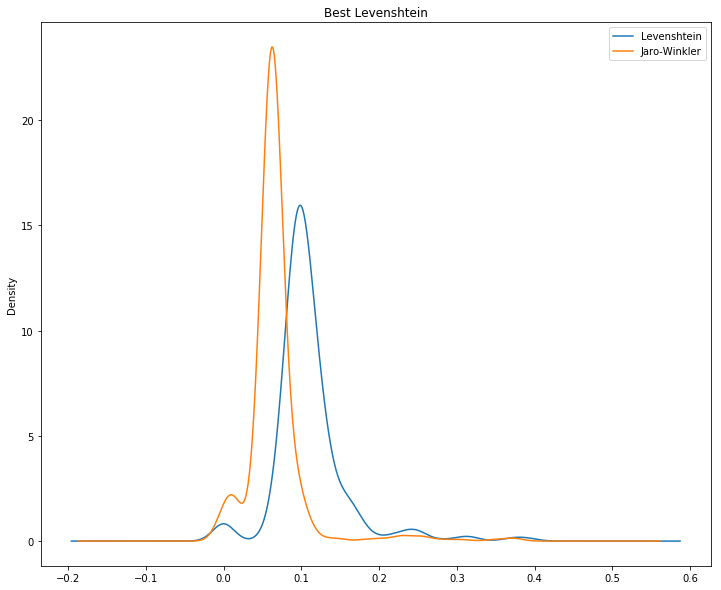

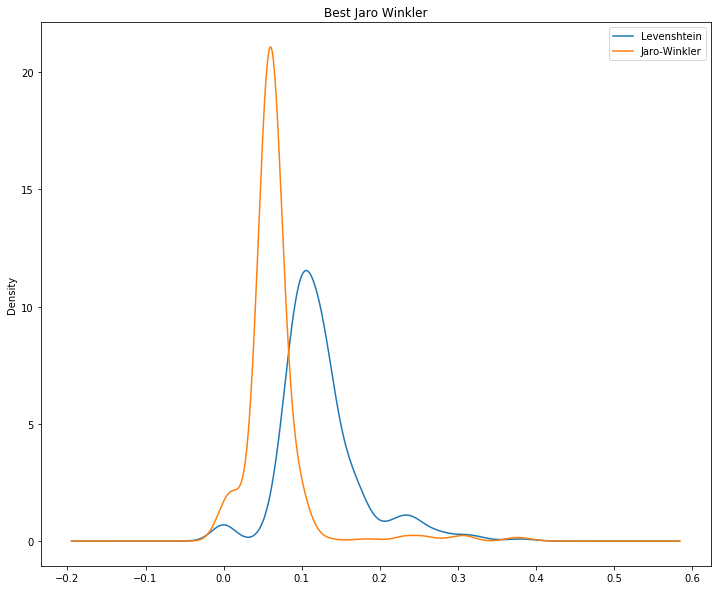

In [459]:
plt.figure(figsize=(12, 10))
best_combos_lev.loc[best_combos_lev.dist_lev<0.4].dist_lev.plot.kde(label='Levenshtein')
best_combos_lev.loc[best_combos_lev.dist_jw<0.4].dist_jw.plot.kde(label='Jaro-Winkler')
plt.title('Best Levenshtein')
plt.legend()

plt.figure(figsize=(12, 10))
best_combos_jw.loc[best_combos_jw.dist_lev<0.4].dist_lev.plot.kde(label='Levenshtein')
best_combos_jw.loc[best_combos_jw.dist_jw<0.4].dist_jw.plot.kde(label='Jaro-Winkler')
plt.title('Best Jaro Winkler')
plt.legend()

In [460]:
map_1 = best_combos_jw.loc[best_combos_jw.dist_jw<0.07]
map_2 = best_combos_jw.loc[best_combos_jw.dist_lev<0.14]
map_3 = best_combos_lev.loc[best_combos_lev.dist_jw<0.07]
map_4 = best_combos_lev.loc[best_combos_lev.dist_lev<0.1034483]

In [461]:
map_1_final = map_1.loc[map_1.groupby(by='col_tac')['dist_jw'].idxmin()][['col_lam', 'col_tac']]
map_2_final = map_2.loc[map_2.groupby(by='col_tac')['dist_jw'].idxmin()][['col_lam', 'col_tac']]
map_3_final = map_3.loc[map_3.groupby(by='col_tac')['dist_jw'].idxmin()][['col_lam', 'col_tac']]
map_4_final = map_4.loc[map_4.groupby(by='col_tac')['dist_jw'].idxmin()][['col_lam', 'col_tac']]

In [462]:
Reduced_DS_lambada = DS_lambada[list(map_1_final.col_lam)]
Reduced_DS_tacmono = DS_tacmono[list(map_1_final.col_tac)]
Reduced_DS_tacmono.columns = list(map_1_final.col_lam)
final_1 = Reduced_DS_lambada.append(Reduced_DS_tacmono)

Reduced_DS_lambada = DS_lambada[list(map_2_final.col_lam)]
Reduced_DS_tacmono = DS_tacmono[list(map_2_final.col_tac)]
Reduced_DS_tacmono.columns = list(map_2_final.col_lam)
final_2 = Reduced_DS_lambada.append(Reduced_DS_tacmono)

Reduced_DS_lambada = DS_lambada[list(map_3_final.col_lam)]
Reduced_DS_tacmono = DS_tacmono[list(map_3_final.col_tac)]
Reduced_DS_tacmono.columns = list(map_3_final.col_lam)
final_3 = Reduced_DS_lambada.append(Reduced_DS_tacmono)

Reduced_DS_lambada = DS_lambada[list(map_4_final.col_lam)]
Reduced_DS_tacmono = DS_tacmono[list(map_4_final.col_tac)]
Reduced_DS_tacmono.columns = list(map_4_final.col_lam)
final_4 = Reduced_DS_lambada.append(Reduced_DS_tacmono)

# ...train model

In [677]:
Final = final_4
Clinical_only = False
PCA = False
RFECV = False
FDR = True

In [678]:
for col in Final.columns.values:
    try:
        if 'object' in str(Final[col].dtypes):
            try:
                Final[col] = Final[col].astype('float64')                
            except:
                try:
                    Final[col] = Final[col].astype('category')
                except:
                    Final[col] = Final[col].astype('int')
    except:
        Final[col] = Final[col].astype('category')

In [561]:
#for col in Final.columns.values:
#    try:
#        if (Final[col].mean()- Final[col].round().mean())==0.0:
#            Final[col] = Final[col].astype('int')
#    except:
#        continue


In [694]:
Final.target = Final.target.astype('int')
df = pd.get_dummies(Final)
df.fillna(0, inplace=True)
x = df.drop(['target'], axis=1)
y = df['target']


In [ ]:
# alleen klinische data
if Clinical_only:
    x=x[['total transplants', 'leefpat', 'age donor','pra high recipient',
           'cold ischemia time hours', 'cold ischemia time minutes',
           'second warm ischemia period in minutes', 'mm-a', 'mm-b']]
if PCA:
    # PCA
    x = PCA(n_components=50).fit_transform(x)
if RFECV:
    MODEL = ensemble.RandomForestClassifier()
    x = RFECV(step=1, cv=7, n_jobs=8, estimator=MODEL).fit_transform(x,y)

In [696]:
if FDR:
    x_new = SelectFdr(alpha=.5).fit_transform(x,y)
    fdr_support = SelectFdr(alpha=.5).fit(x,y).get_support()
    x.drop(x.columns[~fdr_support], axis=1, inplace=True)

In [ ]:
for col in x.columns.values:
    if "tijdspunt" in col.lower():
        x = x.drop(col,axis=1)

In [699]:
tpot_config = {'sklearn.ensemble.RandomForestClassifier': {
                'n_estimators': [10, 20,30,40],
                'criterion': ["gini"],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 25),
                'min_samples_leaf':  range(1, 25),
                'bootstrap': [False]}}
tpot = TPOTClassifier(generations=4, population_size=15, verbosity=2, config_dict=tpot_config)
tpot.fit(x, y)



Optimization Progress:  40%|████      | 30/75 [00:08<00:15,  2.83pipeline/s]

Generation 1 - Current best internal CV score: 0.8033333333333333


Optimization Progress:  60%|██████    | 45/75 [00:12<00:07,  3.87pipeline/s]

Generation 2 - Current best internal CV score: 0.8099999999999999


Optimization Progress:  80%|████████  | 60/75 [00:17<00:04,  3.15pipeline/s]

Generation 3 - Current best internal CV score: 0.8099999999999999


Generation 4 - Current best internal CV score: 0.8099999999999999

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.8500000000000001, min_samples_leaf=16, min_samples_split=9, n_estimators=10)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'n_estimators': [10, 20, 30, 40], 'criterion': ['gini'], 'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'min_samples_split': range(2, 25), 'min_samples_leaf': range(1, 25), 'bootstrap': [False]}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=4, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
        offspring_size=15, periodic_checkpoint_folder=None,
        population_size=15, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

In [700]:
tpot_config = {'sklearn.linear_model.LogisticRegression': {
                'dual': [True, False],
                'tol': [1e-5, 1e-3, 1e-1],
                 'C': [0.5, 0.8, 1],
                 'max_iter': [30, 60, 100]}}
tpot = TPOTClassifier(generations=4, population_size=15, verbosity=2, config_dict=tpot_config)
tpot.fit(x, y)

Optimization Progress:  43%|████▎     | 32/75 [00:01<00:02, 16.76pipeline/s]

Generation 1 - Current best internal CV score: 0.7557142857142857


Optimization Progress:  61%|██████▏   | 46/75 [00:02<00:01, 17.00pipeline/s]

Generation 2 - Current best internal CV score: 0.7557142857142857


Optimization Progress:  81%|████████▏ | 61/75 [00:03<00:00, 19.03pipeline/s]

Generation 3 - Current best internal CV score: 0.7557142857142857


Generation 4 - Current best internal CV score: 0.7557142857142857

Best pipeline: LogisticRegression(input_matrix, C=1, dual=True, max_iter=60, tol=0.001)


TPOTClassifier(config_dict={'sklearn.linear_model.LogisticRegression': {'dual': [True, False], 'tol': [1e-05, 0.001, 0.1], 'C': [0.5, 0.8, 1], 'max_iter': [30, 60, 100]}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=4, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
        offspring_size=15, periodic_checkpoint_folder=None,
        population_size=15, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

In [701]:
tpot_config = {'sklearn.svm.SVC': {
                'gamma': [1e-2, 1e-1, 1, 10],
                'tol': [1e-5, 1e-3, 1e-1],
                 'C': [0.5, 0.8, 1],
                 'max_iter': [30, 60, 100],
                 'probability': [True]}}
tpot = TPOTClassifier(generations=4, population_size=15, verbosity=2, config_dict=tpot_config)
tpot.fit(x, y)

Optimization Progress:  44%|████▍     | 33/75 [00:01<00:02, 17.92pipeline/s]

Generation 1 - Current best internal CV score: 0.7819047619047619


Optimization Progress:  67%|██████▋   | 50/75 [00:02<00:01, 19.13pipeline/s]

Generation 2 - Current best internal CV score: 0.7819047619047619


Optimization Progress:  85%|████████▌ | 64/75 [00:03<00:00, 19.63pipeline/s]

Generation 3 - Current best internal CV score: 0.7819047619047619


Generation 4 - Current best internal CV score: 0.7819047619047619

Best pipeline: SVC(input_matrix, C=0.5, gamma=1, max_iter=60, probability=True, tol=0.001)


TPOTClassifier(config_dict={'sklearn.svm.SVC': {'gamma': [0.01, 0.1, 1, 10], 'tol': [1e-05, 0.001, 0.1], 'C': [0.5, 0.8, 1], 'max_iter': [30, 60, 100], 'probability': [True]}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=4, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
        offspring_size=15, periodic_checkpoint_folder=None,
        population_size=15, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

In [752]:
MODEL = ensemble.RandomForestClassifier(bootstrap=False, 
                                        criterion='gini', 
                                        max_features=0.76, 
                                        min_samples_leaf=11, 
                                        min_samples_split=2, 
                                        n_estimators=12)
cv_results = cross_val_predict(MODEL, x, y, cv = 10)

print(metrics.classification_report(y, cv_results))
print("Total accuracy: {}".format(metrics.accuracy_score(y, cv_results)))
print("AUC/ROC: {}".format(metrics.roc_auc_score(y, cv_results)))

             precision    recall  f1-score   support

          0       0.80      0.95      0.86       111
          1       0.40      0.13      0.20        31

avg / total       0.71      0.77      0.72       142

Total accuracy: 0.7676056338028169
AUC/ROC: 0.537489102005231


In [753]:
acc = np.zeros(shape=y.shape)
count=0
maxrun = 50
run = True
importances_sum = 0 

while run:
    splitter = StratifiedKFold(10)
    #
    for train_index, test_index in splitter.split(x, y):
        x_train, x_test = np.array(x)[train_index], np.array(x)[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]       
        MODEL.fit(x_train,y_train)
        pred_test_ = MODEL.predict(x_test) #[np.round(l[1]).astype(int) for l in pred_test]
        acc[test_index] = metrics.accuracy_score(y_test, pred_test_)    

        importances = MODEL.feature_importances_
        importances_sum += importances
        
    count+=1        
    if count>maxrun:
        run=False

print("Mean acc:{}, Var acc:{}".format(np.mean(acc), np.var(acc)))
indices = np.argsort(importances_sum)[::-1]    

for f in range(x.shape[1]):
    print("%d. %s (%f)" % (f + 1, x.columns[indices[f]], importances_sum[indices[f]]))

Mean acc:0.7887323943661971, Var acc:0.001643664805735822
1. pra high recipient (183.549797)
2. second warm ischemia period in minutes (57.063262)
3. cold ischemia time hours (43.819510)
4. basic_ln_cd45+_leucocytes_%_gated (34.310349)
5. age donor (28.104122)
6. tcel_ln_cd8+cd28+cd57+_%gated (23.656379)
7. bcel_ln_igd-igm+cd27+cd38high_%gated (22.749130)
8. leefpat (21.369185)
9. basic_ln_cd14+cd16high_monocytes_%_gated (18.359284)
10. bcel_pb_igd+cd27+_(marginal_zone_b_cells)_absoluut (11.960258)
11. mm-b (11.877694)
12. tcel_ln_cd8+emra_cd28+cd57+_%gated (7.106156)
13. tcel_ln_cd4+cd28+cd57-_absoluut (3.323185)
14. basic_ln_cd14highcd16+_monocytes_absoluut (2.992456)
15. tcel_ln_cd4+cd27+cd28+_absoluut (2.937021)
16. basic_ln_cd14+cd16high_monocytes_absoluut (2.888780)
17. tcel_ln_cd8+emra_cd28-cd57-_%gated (2.715843)
18. bcel_ln_transitional_b_cell_%gated (1.956586)
19. basic_ln_cd14highcd16-_monocytes_%_gated (1.892224)
20. tcel_ln_cd4+emra_cd28-cd57+_%gated (1.884719)
21. tcel_ln

In [754]:
MODEL = LogisticRegressionCV()
cv_results = cross_val_predict(MODEL, x, y, cv = 10)
print(metrics.classification_report(y, cv_results))
print("Total accuracy: {}".format(metrics.accuracy_score(y, cv_results)))
print("AUC/ROC: {}".format(metrics.roc_auc_score(y, cv_results)))
MODEL = LogisticRegressionCV()
MODEL.fit(x,y)
res = MODEL.coef_[0,:]

             precision    recall  f1-score   support

          0       0.80      0.91      0.85       111
          1       0.33      0.16      0.22        31

avg / total       0.69      0.75      0.71       142

Total accuracy: 0.7464788732394366
AUC/ROC: 0.5356001162452776


In [723]:
MODEL = SVM(C=0.1, gamma=0.06, max_iter=25, probability=False, tol=0.01)
cv_results = cross_val_predict(MODEL, x, y, cv = 10)
print(metrics.classification_report(y, cv_results))
print("Total accuracy: {}".format(metrics.accuracy_score(y, cv_results)))
print("AUC/ROC: {}".format(metrics.roc_auc_score(y, cv_results)))

             precision    recall  f1-score   support

          0       0.80      0.92      0.86       111
          1       0.40      0.19      0.26        31

avg / total       0.72      0.76      0.73       142

Total accuracy: 0.7605633802816901
AUC/ROC: 0.5562336530078466


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: 

In [751]:
MODEL_RF1 = ensemble.RandomForestClassifier(bootstrap=False, criterion='gini', max_features=0.86, 
                                        min_samples_leaf=15, min_samples_split=10, n_estimators=20)
MODEL_RF2 = ensemble.RandomForestClassifier(bootstrap=False, criterion='gini', max_features=0.5, 
                                        min_samples_leaf=10, min_samples_split=15, n_estimators=30)
MODEL_RF3 = ensemble.RandomForestClassifier(bootstrap=False, criterion='gini',max_features=0.76, 
                                        min_samples_leaf=11, min_samples_split=2, n_estimators=12)
MODEL_LR = LogisticRegressionCV(dual=False, max_iter=100, tol=0.1)

MODEL_SVM = SVM(C=0.1, gamma=0.06, max_iter=25, probability=True, tol=0.01)

MODEL_BAG = VotingClassifier(estimators=[('RF1', MODEL_RF1), ('RF2', MODEL_RF2), ('RF3', MODEL_RF3), 
                                         ('LR', MODEL_LR), ('SVM', MODEL_SVM)], 
                        voting='soft', weights=[1,1,2,1,1])

cv_results = cross_val_predict(MODEL_BAG, x, y, cv = 10)
print(metrics.classification_report(y, cv_results))
print("Total accuracy: {}".format(metrics.accuracy_score(y, cv_results)))
print("AUC/ROC: {}".format(metrics.roc_auc_score(y, cv_results)))


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empt

             precision    recall  f1-score   support

          0       0.81      0.94      0.87       111
          1       0.50      0.23      0.31        31

avg / total       0.74      0.78      0.75       142

Total accuracy: 0.7816901408450704
AUC/ROC: 0.5813716942749201


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [755]:
importances_df = pd.DataFrame()
importances_df['param'] = x.columns[indices[:]]
importances_df['importances'] = importances_sum[indices[:]]
importances_df.index = importances_df.param
importances_df.drop('param', axis=1, inplace=True)
##
result = pd.DataFrame()
result['coeff'] = 0 
result['coeff'] = res
result['param'] = ''
result['param'] = x.columns.values
result.index= result['param']
result.drop('param', axis=1, inplace=True)

In [756]:
result_final = importances_df.join(result, how='outer')
result_final = result_final.apply(lambda x: x/x.abs().max())
result_final = result_final.sort_values(by='importances', ascending=False)
result_final.to_csv('Combined.csv')

In [757]:
result_final

,importances,coeff
param,,
pra high recipient,1.000000,1.000000
second warm ischemia period in minutes,0.310887,0.406374
cold ischemia time hours,0.238734,0.148248
basic_ln_cd45+_leucocytes_%_gated,0.186927,0.300753
age donor,0.153114,0.495266
tcel_ln_cd8+cd28+cd57+_%gated,0.128883,-0.003320
bcel_ln_igd-igm+cd27+cd38high_%gated,0.123940,-0.266359
leefpat,0.116422,-0.691169
basic_ln_cd14+cd16high_monocytes_%_gated,0.100023,-0.249137


In [759]:
x.dtypes

age donor                                                                            float64
basic_ln_cd14+cd16high_monocytes_%_gated                                             float64
basic_ln_cd14+cd16high_monocytes_absoluut                                            float64
basic_ln_cd14highcd16+_monocytes_absoluut                                            float64
basic_ln_cd14highcd16-_monocytes_%_gated                                             float64
basic_ln_cd14highcd16-_monocytes_absoluut                                            float64
basic_ln_cd16+cd56dim_nk_%_gated                                                     float64
basic_ln_cd16+cd56high_nk_absoluut                                                   float64
basic_ln_cd16-cd56dim_nk_%_gated                                                     float64
basic_ln_cd16-cd56dim_nk_absoluut                                                    float64
basic_ln_cd3+_t_cells_%_gated                                         